In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## 1º Step:
#### Get the dataset, in this case is a 1D gaussian distribution with mu = 0.5 and sigma = 0.5:

In [2]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 4
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

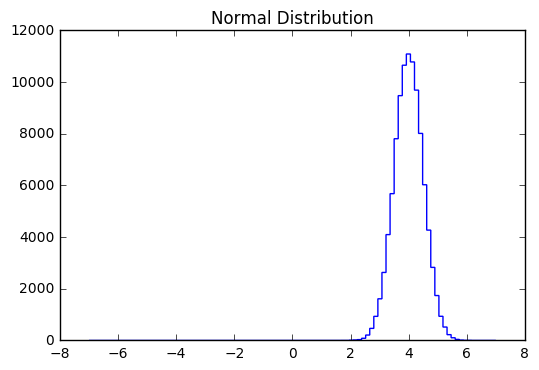

In [3]:
data = DataDistribution()
x = data.sample(100000)
plt.hist(x,bins=100,range=(-7,7),facecolor="r", histtype = 'step')
plt.title('Normal Distribution')
plt.show()

#### Generate G inputs ( z )

In [4]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

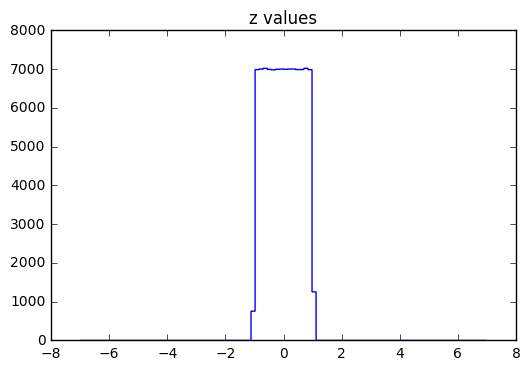

In [7]:
gen = GeneratorDistribution(1)
z = gen.sample(100000)
plt.hist(z,bins=100,range=(-7,7),facecolor="r", histtype = 'step')
plt.title('z values')
plt.show()

Note that z is one value between -1 and 1, this input is a random vector for G that will try generate a new distribution. I hope this new distribution will be approximately a normal distribution with mu=4 and sigma=0.5

## 2º Step: Define the models

Linear creates a new fully connected layer

In [6]:
def linear(inputs, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [inputs.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(inputs, w) + b

The generator is a linear transformation passed through a nonlinearity (a softplus function), followed by another linear transformation.

In [7]:
def generator(inputs, hidden_size):
    h0 = tf.nn.softplus(linear(inputs, hidden_size, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1

In this case we found that it was important to make sure that the discriminator is more powerful than the generator, as otherwise it did not have sufficient capacity to learn to be able to distinguish accurately between generated and real samples. So we made it a deeper neural network, with a larger number of dimensions. It uses tanh nonlinearities in all layers except the final one, which is a sigmoid (the output of which we can interpret as a probability).

In [8]:
def discriminator(inputs, hidden_size, minibatch_layer=False):
    h0 = tf.tanh(linear(inputs, hidden_size * 2, 'd0'))
    h1 = tf.tanh(linear(h0, hidden_size * 2, 'd1'))
    
    # without the minibatch layer, the discriminator needs an additional layer
    # to have enough capacity to separate the two distributions correctly
    if minibatch_layer:
        h2 = minibatch(h1)
    else:
        h2 = tf.tanh(linear(h1, hidden_size * 2, scope='d2'))
    
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

## 3º Step: Build graph

#### Define the graph connections

In [9]:
hidden_size = 20
batch_size = 300

with tf.variable_scope('G'):
    z = tf.placeholder(tf.float32, shape=(None , 1))
    G = generator(z, hidden_size)

with tf.variable_scope('D') as scope:
    x = tf.placeholder(tf.float32, shape=(None , 1))
    D1 = discriminator(x, hidden_size)
    scope.reuse_variables()
    D2 = discriminator(G, hidden_size)

#### Define the loss function

In [10]:
loss_d = tf.reduce_mean(-tf.log(D1) - tf.log(1 - D2))
loss_g = tf.reduce_mean(-tf.log(D2))

#### Define the optimizer method

In [11]:
def optimizer(loss, var_list):
    initial_learning_rate = 0.005
    decay = 0.95
    num_decay_steps = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    
    return optimizer

#### Define the trainable variables

In [12]:
vars = tf.trainable_variables()
d_params = [v for v in vars if v.name.startswith('D/')]
g_params = [v for v in vars if v.name.startswith('G/')]

#### Define the last conection on graph (optimizers)

In [13]:
opt_d = optimizer(loss_d, d_params)
opt_g = optimizer(loss_g, g_params)

## 4º Step: Train the model

At step 0
Discriminator loss: 6.41359376907
Generator loss: 3.0346455574


At step 400
Discriminator loss: 1.3928784132
Generator loss: 0.689239382744


At step 800
Discriminator loss: 1.38468205929
Generator loss: 0.696840703487


At step 1200
Discriminator loss: 1.37149918079
Generator loss: 0.701763510704


Using model


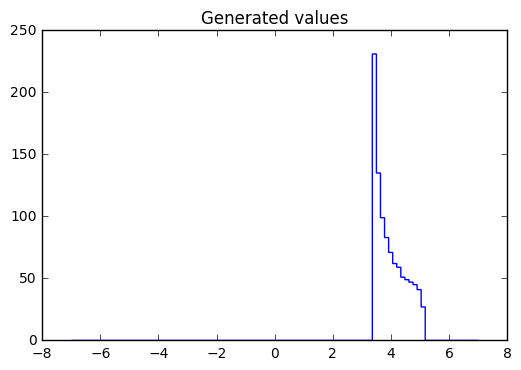

In [14]:
num_steps = 1200
pre_num_steps = 1000

init_op = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init_op)

    for step in range(num_steps+1):
        # update discriminator
        x_ = data.sample(batch_size).astype(np.float32)
        x_ = np.reshape(x_, (batch_size, 1))

        z_ = gen.sample(batch_size).astype(np.float32)
        z_ = np.reshape(z_, (batch_size, 1))

        loss_d_val, opt_d_val = session.run([loss_d, opt_d], feed_dict={z: z_, x: x_})

        # update generator
        z_ = gen.sample(batch_size).astype(np.float32)
        z_ = np.reshape(z_, (batch_size, 1))
        loss_g_val, opt_g_val = session.run([loss_g, opt_g], feed_dict={z: z_})

        if step%400 == 0:
            print("At step {0}".format(step))
            print("Discriminator loss: {0}".format(loss_d_val))
            print("Generator loss: {0}".format(loss_g_val))
            print("\n")
    
    print('Using model')
    z_ = gen.sample(1000).astype(np.float32)
    z_ = np.reshape(z_, (1000, 1))
    generated = session.run(G, feed_dict={z: z_})
    plt.hist(generated,bins=100,range=(-7,7),facecolor="r", histtype = 'step')
    plt.title('Generated values')
    plt.show()

This makes sense intuitively. The discriminator is looking at individual samples from the real data and from our generator. If the generator just produces the mean value of the real data in this simple example, then it is going to be quite likely to fool the discriminator.

### Use minibatch method on training

#### Define minibatch method:

In [15]:
def minibatch(input, num_kernels=5, kernel_dim=3):
    x = linear(input, num_kernels * kernel_dim, scope='minibatch', stddev=0.02)
    activation = tf.reshape(x, (-1, num_kernels, kernel_dim))
    diffs = tf.expand_dims(activation, 3) - \
        tf.expand_dims(tf.transpose(activation, [1, 2, 0]), 0)
    abs_diffs = tf.reduce_sum(tf.abs(diffs), 2)
    minibatch_features = tf.reduce_sum(tf.exp(-abs_diffs), 2)
    return tf.concat(1, [input, minibatch_features])

#### Redefine graph:

In [16]:
hidden_size = 20
batch_size = 300

with tf.variable_scope('G2'):
    z = tf.placeholder(tf.float32, shape=(None , 1))
    G = generator(z, hidden_size)

with tf.variable_scope('D2') as scope:
    x = tf.placeholder(tf.float32, shape=(None , 1))
    D1 = discriminator(x, hidden_size, minibatch_layer=True)
    scope.reuse_variables()
    D2 = discriminator(G, hidden_size, minibatch_layer=True)

#### Same process ( define loss, get trainable variables, define optimizer, train model )

In [17]:
loss_d = tf.reduce_mean(-tf.log(D1) - tf.log(1 - D2))
loss_g = tf.reduce_mean(-tf.log(D2))

vars = tf.trainable_variables()
d_params = [v for v in vars if v.name.startswith('D2/')]
g_params = [v for v in vars if v.name.startswith('G2/')]

opt_d = optimizer(loss_d, d_params)
opt_g = optimizer(loss_g, g_params)

In [18]:
num_steps = 1200

init_op = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(init_op)

    for step in range(num_steps+1):
        # update discriminator
        x_ = data.sample(batch_size).astype(np.float32)
        x_ = np.reshape(x_, (batch_size, 1))

        z_ = gen.sample(batch_size).astype(np.float32)
        z_ = np.reshape(z_, (batch_size, 1))

        loss_d_val, opt_d_val = session.run([loss_d, opt_d], feed_dict={z: z_, x: x_})

        # update generator
        z_ = gen.sample(batch_size).astype(np.float32)
        z_ = np.reshape(z_, (batch_size, 1))
        loss_g_val, opt_g_val = session.run([loss_g, opt_g], feed_dict={z: z_})

        if step%400 == 0:
            print("At step {0}".format(step))
            print("Discriminator loss: {0}".format(loss_d_val))
            print("Generator loss: {0}".format(loss_g_val))
            print("\n")
    
    print('Using model')
    z_ = gen.sample(1000).astype(np.float32)
    z_ = np.reshape(z_, (1000, 1))
    generated = session.run(G, feed_dict={z: z_})
    plt.hist(generated,bins=100,range=(-7,7),facecolor="r", histtype = 'step')
    plt.title('Generated values')
    plt.show()

At step 0
Discriminator loss: inf
Generator loss: nan




KeyboardInterrupt: 